# OEMLHAT - Tutorial of execution

This notebook shows an example of execution to declare, use and evaluate a Online Ensemble of Multi-Label Hoeffding Adaptive Tree (`OEMLHAT`) model, together with the 3 predictive maintenance problems presented in this repository and addressed from a multi-label online learning perspective.

## Defining the execution environment

OEMLHAT and its associated experimentation have been programmed in Python language, using mainly the [River](https://riverml.xyz) library for online learning. The complete specification for creating the environment of execution is under the file [environment.yml](environment.yml), that can be used together with [Conda](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file).

In [ ]:
conda env create -f environment.yml

## Declaring the learning model

Below is shown how an instance of `OEMLHAT` would be initialized with the default parameters:

* Number of base trees: `n_models=10`
* Percentage of the input feature's space using for subspacing: `subspace_size=0.6`
* Parameter $\lambda$ for the bootsraping process based on the Poisson distribution: `lam=5`

And the base tree specific parameters: 

* Leaf grace period $k_{spl}$: `grace_period=205`.
* Significance level in Hoeffding bound for spliting nodes $\delta_{spl}$: `delta=1e-7`.
* Alternate tree grace period $k_{alt}$: `drift_window_threshold=208`.
* Significance level in Hoeffdinb bound for switching alternate trees $\delta_{alt}$: `switch_significance=0.036`.
* Cardinality threshold $\eta$ and number of instance a leaf should observe between split attemps grouped in: `grace_period=750`.
* Metric to study the concept drift $e$: `perf_metric=MicroAverage(F1())`.
* Low cardinality classifier: `low_card_clf=LabelCombination(KNNClassifier(13))`.
* High cardinality classifier: `high_card_clf=BinaryRelevance(BaggingClassifier(LogisticRegression(), n_models=10))`

In [1]:
from oemlhat import OEMLHAT

model = OEMLHAT(grouping_features=['Type_H', 'Type_L', 'Type_M'])
model

OEMLHAT (
  n_models=10
  subspace_size=0.6
  lam=5
  disable_weighted_vote=False
  grace_period=205
  delta=3e-07
  tau=0.05
  cardinality_th=135
  entropy_th=0.75
  drift_window_threshold=208
  perf_metric=MicroAverage(F1): 0.00%
  switch_significance=0.036
  lc_n_neighbors=13
  lc_window_size=140
  hc_lr=0.95
  seed=1
  grouping_features=['Type_H', 'Type_L', 'Type_M']
)

At the beginning, since no data has been received yet, the model does not have any tree:

In [9]:
for tree in model:
    display(tree.summary)

## Loading the predictive maintenance problem as a data stream

This repository allows the use of three public multi-label problems, providing the interface for loading them as streams. Specifically, the three problems are the following:

* The **AI4I 2020 Predictive Maintenance Dataset**: A synthetic dataset that reflects real predictive maintenance data encountered in industry. [[Reference]](https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset).
* The **Naval Propulsion System (NPS) Dataset**: Data generated from a sophisticated simulator of a Gas Turbines (GT), mounted on a Frigate characterized by a COmbined Diesel eLectric And Gas (CODLAG) propulsion plant type. [[Reference]](https://archive.ics.uci.edu/dataset/316/condition+based+maintenance+of+naval+propulsion+plants).
* The **Alarms Logs in Packaging Industry (ALPI)** dataset consists of a sequence of alarms logged by packaging equipment in an industrial environment. The collection includes data logged by 20 machines, deployed in different plants around the world, from 2019-02-21 to 2020-06-17. There are 154 distinct alarm codes, whose distribution is highly unbalanced. In our implementation, the stream is loaded by machine, and the length of the rolling windows for input and output can be also specified. The machine ID is an integer in [0, 19]. [[Reference]](https://ieee-dataport.org/open-access/alarm-logs-packaging-industry-alpi).

In [2]:
from datasets.multioutput import *

stream = Ai4i()
stream

The AI4I 2020 Predictive Maintenance Dataset is a synthetic dataset that reflects real predictive maintenance data encountered in industry.

Source: https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

      Name  Ai4i                                                                                      
      Task  Multi-output binary classification                                                        
   Samples  10,000                                                                                    
  Features  14                                                                                        
   Outputs  5                                                                                         
    Sparse  False                                                                                     
      Path  /Users/aurora/river_data/Ai4i/ai4i2020.csv                                                
       URL  https://archive.ics.uci.edu/static/p

In [1]:
from datasets.multioutput import *

stream = NPS()
stream

Condition Based Maintenance of Naval Propulsion Plants. Data have been generated from a sophisticated simulator of a Gas Turbines (GT), mounted on a Frigate characterized by a COmbined Diesel eLectric And Gas (CODLAG) propulsion plant type.

Source: https://archive.ics.uci.edu/dataset/316/condition+based+maintenance+of+naval+propulsion+plants

    Name  NPS                                                                
    Task  Multi-output binary classification                                 
 Samples  65,473                                                             
Features  23                                                                 
 Outputs  4                                                                  
  Sparse  False                                                              
    Path  /Users/aurora/git/OEMLHAT4PdM/src/datasets/multioutput/nps_sp15.csv

In [1]:
from datasets.multioutput import *

stream = Alpi(machine=0)
stream

The Alarms Logs in Packaging Industry (ALPI) dataset consists of a sequence of alarms logged by packaging equipment in an industrial environment. The collection includes data logged by 20 machines, deployed in different plants around the world, from 2019-02-21 to 2020-06-17. There are 154 distinct alarm codes, whose distribution is highly unbalanced.

Source: https://ieee-dataport.org/open-access/alarm-logs-packaging-industry-alpi

Parameters:
- machine: serial number of the machine to use, that can take numeric values from 0 to 19.
- input_win: size of the input window in number of entries.
- output_win: size of the output window in number of entries.
- delta: time difference between the end of the input window and the start of the output window, in number of entries.
- sigma: stride between consecutive input windows, in number of entries.

    Name  Alpi                                                           
    Task  Multi-output binary classification                            

### Access to the stream

Using Python iterators one can access to the stream sample-by-sample. Both input and multi-label output are provided in a dictonary-based format.

In [5]:
# Using Ai4i as data stream

x, y = next(iter(stream))
x

{'Type': 'M',
 'Air temperature [K]': 298.1,
 'Process temperature [K]': 308.6,
 'Rotational speed [rpm]': 1551.0,
 'Torque [Nm]': 42.8,
 'Tool wear [min]': 0.0}

In [4]:
y

{'TWF': False, 'HDF': False, 'PWF': False, 'OSF': False, 'RNF': False}

## Runing the model

Prequential evaluation is the canonical form of asses the performance of an model in an data stream scenario. This evaluation framework allows to check the performance of the model at each step of the stream and how well it adapts to the concept drift. Then, it passes the sample with the corresponding learning target to the model to train it incrementally.

The code below allows to apply prequential evaluation to OEMLHAT by measuring its performance every 100 steps in the data stream of the AI4I dataset.

In [4]:
import evaluate
import numbers
from river.compose import SelectType
from river.metrics import F1
from river.metrics.base import Metrics
from river.metrics.multioutput import ExactMatch
from river import preprocessing
from metrics.multioutput import *

pp = SelectType(numbers.Number)
pp += SelectType(str) | preprocessing.OneHotEncoder()
pipeline = pp | model

evaluate.progressive_val_score(dataset=stream, model=pipeline, metric=Metrics([ExactMatch(), MacroAverage(F1()), MicroAverage(F1())]), show_memory=True, print_every=100)

[100] ExactMatch: 0.00%
MacroAverage(F1): 100.00%
MicroAverage(F1): 0.00% – 4.56 MB
[200] ExactMatch: 100.00%
MacroAverage(F1): 0.00%
MicroAverage(F1): 0.00% – 4.72 MB
[300] ExactMatch: 95.24%
MacroAverage(F1): 0.00%
MicroAverage(F1): 0.00% – 4.97 MB
[400] ExactMatch: 97.07%
MacroAverage(F1): 10.00%
MicroAverage(F1): 25.00% – 4.97 MB
[500] ExactMatch: 97.70%
MacroAverage(F1): 11.43%
MicroAverage(F1): 36.36% – 4.99 MB
[600] ExactMatch: 98.02%
MacroAverage(F1): 11.43%
MicroAverage(F1): 33.33% – 5.19 MB
[700] ExactMatch: 98.22%
MacroAverage(F1): 10.00%
MicroAverage(F1): 30.77% – 5.02 MB
[800] ExactMatch: 98.35%
MacroAverage(F1): 10.00%
MicroAverage(F1): 28.57% – 5.04 MB
[900] ExactMatch: 98.44%
MacroAverage(F1): 10.91%
MicroAverage(F1): 35.29% – 4.85 MB
[1,000] ExactMatch: 98.39%
MacroAverage(F1): 10.00%
MicroAverage(F1): 31.58% – 4.66 MB
[1,100] ExactMatch: 98.01%
MacroAverage(F1): 8.57%
MicroAverage(F1): 25.00% – 5.04 MB
[1,200] ExactMatch: 97.61%
MacroAverage(F1): 7.06%
MicroAverage(F1

ExactMatch: 97.02%
MacroAverage(F1): 15.09%
MicroAverage(F1): 29.55%

## Visualization of results

Once OEMLHAT is initialized, there are several ways of visualizing the tree generated for each of the 10 base models that compose the ensemble. With the following code, it can be seen each tree with three different functions:
* `summary` provides a summary of the current structure of the tree attending to number of branches and leaves active and pruned.
* `to_dataframe()` provides a summary of the current structure of the tree indicating for each node several information related to its stats and configuration.
* `draw()` draws the tree graphically, showing per each node the probability of each label.

Tree 0


{'n_nodes': 1,
 'n_branches': 0,
 'n_leaves': 1,
 'n_active_leaves': 1,
 'n_inactive_leaves': 0,
 'height': 1,
 'total_observed_weight': 68866.0,
 'n_current_alternate_trees': 0,
 'n_pruned_alternate_trees': 5,
 'n_switched_alternate_trees': 1}

None

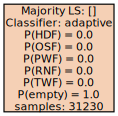

Tree 1


{'n_nodes': 4,
 'n_branches': 1,
 'n_leaves': 2,
 'n_active_leaves': 2,
 'n_inactive_leaves': 0,
 'height': 2,
 'total_observed_weight': 68855.0,
 'n_current_alternate_trees': 1,
 'n_pruned_alternate_trees': 10,
 'n_switched_alternate_trees': 1}

,parent,is_leaf,depth,drift_detector,_mean_perf,_post_drift_weight,warning,stats,feature,threshold,...,_alternate_tree,splitter,splitters,_disabled_attrs,_last_split_attempt_at,current_weight,pure_clf,entropy,low_card_clf,high_card_clf
node,,,,,,,,,,,,,,,,,,,,,
0,<NA>,False,0,ADWIN,MicroAverage(F1): 3.17%,5492,False,"{'OSF': 445, 'total': 44666, 'empty': 43059, '...",Tool wear [min],184.0,...,MLHAToCLeaf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,<NA>,True,0,ADWIN,MicroAverage(F1): 0.00%,132,False,"{'PWF': 4, 'OSF': 4, 'total': 136, 'empty': 132}",NaN,NaN,...,NaN,GaussianSplitter,"{'Rotational speed [rpm]': GaussianSplitter, '...",{},0.000000,136.0,MajorityLabelset,0.0,LabelCombination,"[TWF, HDF, PWF, OSF, RNF]"
2,0,True,1,ADWIN,MicroAverage(F1): 3.17%,5492,False,"{'OSF': 35.493161428727106, 'total': 39327.781...",NaN,NaN,...,NaN,GaussianSplitter,"{'Rotational speed [rpm]': GaussianSplitter, '...",{},34621.781305,4706.0,MajorityLabelset,0.0,LabelCombination,"[TWF, HDF, PWF, OSF, RNF]"
3,0,True,1,ADWIN,MicroAverage(F1): 3.17%,5438,False,"{'OSF': 409.5068385712729, 'total': 5338.21869...",NaN,NaN,...,NaN,GaussianSplitter,"{'Rotational speed [rpm]': GaussianSplitter, '...",{},4552.218695,786.0,MajorityLabelset,0.0,LabelCombination,"[TWF, HDF, PWF, OSF, RNF]"


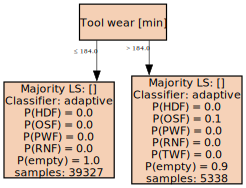

Tree 2


{'n_nodes': 1,
 'n_branches': 0,
 'n_leaves': 1,
 'n_active_leaves': 1,
 'n_inactive_leaves': 0,
 'height': 1,
 'total_observed_weight': 68979.0,
 'n_current_alternate_trees': 0,
 'n_pruned_alternate_trees': 87,
 'n_switched_alternate_trees': 6}

None

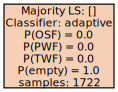

Tree 3


{'n_nodes': 1,
 'n_branches': 0,
 'n_leaves': 1,
 'n_active_leaves': 1,
 'n_inactive_leaves': 0,
 'height': 1,
 'total_observed_weight': 69108.0,
 'n_current_alternate_trees': 0,
 'n_pruned_alternate_trees': 4,
 'n_switched_alternate_trees': 1}

None

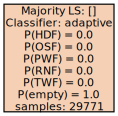

Tree 4


{'n_nodes': 1,
 'n_branches': 0,
 'n_leaves': 1,
 'n_active_leaves': 1,
 'n_inactive_leaves': 0,
 'height': 1,
 'total_observed_weight': 69111.0,
 'n_current_alternate_trees': 0,
 'n_pruned_alternate_trees': 4,
 'n_switched_alternate_trees': 1}

None

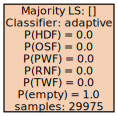

Tree 5


{'n_nodes': 1,
 'n_branches': 0,
 'n_leaves': 1,
 'n_active_leaves': 1,
 'n_inactive_leaves': 0,
 'height': 1,
 'total_observed_weight': 69213.0,
 'n_current_alternate_trees': 0,
 'n_pruned_alternate_trees': 50,
 'n_switched_alternate_trees': 1}

None

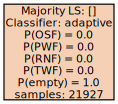

Tree 6


{'n_nodes': 1,
 'n_branches': 0,
 'n_leaves': 1,
 'n_active_leaves': 1,
 'n_inactive_leaves': 0,
 'height': 1,
 'total_observed_weight': 68491.0,
 'n_current_alternate_trees': 0,
 'n_pruned_alternate_trees': 46,
 'n_switched_alternate_trees': 2}

None

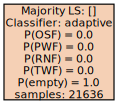

Tree 7


{'n_nodes': 1,
 'n_branches': 0,
 'n_leaves': 1,
 'n_active_leaves': 1,
 'n_inactive_leaves': 0,
 'height': 1,
 'total_observed_weight': 69167.0,
 'n_current_alternate_trees': 0,
 'n_pruned_alternate_trees': 65,
 'n_switched_alternate_trees': 1}

None

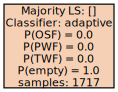

Tree 8


{'n_nodes': 1,
 'n_branches': 0,
 'n_leaves': 1,
 'n_active_leaves': 1,
 'n_inactive_leaves': 0,
 'height': 1,
 'total_observed_weight': 68470.0,
 'n_current_alternate_trees': 0,
 'n_pruned_alternate_trees': 6,
 'n_switched_alternate_trees': 1}

None

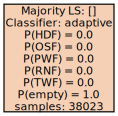

Tree 9


{'n_nodes': 1,
 'n_branches': 0,
 'n_leaves': 1,
 'n_active_leaves': 1,
 'n_inactive_leaves': 0,
 'height': 1,
 'total_observed_weight': 68820.0,
 'n_current_alternate_trees': 0,
 'n_pruned_alternate_trees': 2,
 'n_switched_alternate_trees': 1}

None

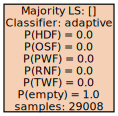

Tree 10


{'n_nodes': 1,
 'n_branches': 0,
 'n_leaves': 1,
 'n_active_leaves': 1,
 'n_inactive_leaves': 0,
 'height': 1,
 'total_observed_weight': 68598.0,
 'n_current_alternate_trees': 0,
 'n_pruned_alternate_trees': 3,
 'n_switched_alternate_trees': 1}

None

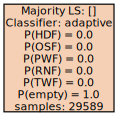

In [8]:
for i, tree in enumerate(model):
    print(f'Tree {i}')
    display(tree.model.summary)
    display(tree.model.to_dataframe())
    display(tree.model.draw())